### V3: Fine-Tune DistilBERT
- Train Data
- Stride 64
- Down Sampling 'O' Label 0.30

Trained on local machine with RTX 3050 x1

Leaderboard 
- Public Score: 0.87546
- Private Score: 0.89158

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from datasets import Dataset
from functools import partial
from seqeval.metrics import accuracy_score, classification_report
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from tqdm import tqdm

In [2]:
class Setting:
    seed = 42
    
    # data
    data = './data/pii-detection-removal-from-educational-data/train.json'
    down_sample_ratio = 0.30
    
    # model
    model_checkpoint = "./model/distilbert/distilbert-base-uncased"
    model_train = './model/v3_0.30/train'
    model_final = './model/v3_0.30/final'
    max_length = 512
    stride = 64
    
    # hyperparameter
    epochs = 5
    learning_rate = 3e-5
    warmup_ratio = 0.1
    lr_scheduler_type='cosine'
    weight_decay = 0.01
    grad_steps = 2
    batch_size = 8
    
    # PII (NER) tags
    labels = ["B-EMAIL", "B-ID_NUM", "B-NAME_STUDENT", "B-PHONE_NUM",
              "B-STREET_ADDRESS", "B-URL_PERSONAL", "B-USERNAME",
              "I-ID_NUM", "I-NAME_STUDENT", "I-PHONE_NUM",
              "I-STREET_ADDRESS","I-URL_PERSONAL","O"]
    id2label = dict(enumerate(labels)) # integer label to BIO format label mapping
    label2id = {v:k for k,v in id2label.items()} # BIO format label to integer label mapping
    num_labels = len(labels) # number of PII (NER) tags

In [3]:
np.random.seed(Setting.seed)
torch.manual_seed(Setting.seed)

In [4]:
df = pd.read_json(Setting.data)
df.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


In [5]:
df = df[['document', 'tokens', 'labels']]
df.rename(columns={"labels": "pii_labels"}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6807 entries, 0 to 6806
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   document    6807 non-null   int64 
 1   tokens      6807 non-null   object
 2   pii_labels  6807 non-null   object
dtypes: int64(1), object(2)
memory usage: 159.7+ KB


In [6]:
def plot_bar_chart(data, target_column, title, xlabel, ylabel):
    target = data[target_column].value_counts(sort=False).reset_index(name='total')
    ax = sns.barplot(
        data=target,
        y='total',
        x=target_column, 
        hue=target_column,
        palette='cool',
        estimator=lambda x: sum(x)*100.00/target['total'].sum())
    plt.tight_layout()
    plt.xlabel(xlabel, fontdict={'weight': 'bold'})
    plt.ylabel(ylabel, fontdict={'weight': 'bold'})
    plt.title(title)
    plt.xticks(rotation=0)
    plt.tick_params(axis='both', which='major', labelsize=9)
    # show percentage on bar for first 3 bars
    for index, row in target.iterrows():
        y = row.total*100.00/target['total'].sum()
        ax.text(row.name, y + 0.15, f'{y:.2f}%', fontsize=9)        
    ax.get_legend().remove()
    plt.show()

def down_sample(df, down_sample_ratio, seed):
    df['non_pii_entity_only'] = df['pii_labels'].apply(lambda x: sum(label=='O' for label in x)==len(x))
    
    df_non_pii_entity_only = df[df['non_pii_entity_only']].sample(frac=down_sample_ratio, random_state=seed)
    df_with_pii_entity = df[~df['non_pii_entity_only']]
    df = pd.concat([df_with_pii_entity, df_non_pii_entity_only])
    
    plot_bar_chart(df, 'non_pii_entity_only', "% of Documents with Non-PII Entity ('O' Label) Only", "Non-PII Entity", "Percentage")
    print(df['non_pii_entity_only'].value_counts())
    
    df.drop(columns=['non_pii_entity_only'], inplace=True)
    return df

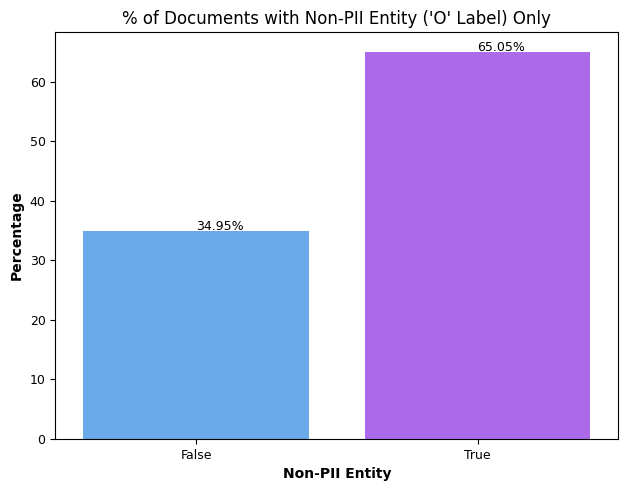

non_pii_entity_only
True     1759
False     945
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 2704 entries, 0 to 5507
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   document    2704 non-null   int64 
 1   tokens      2704 non-null   object
 2   pii_labels  2704 non-null   object
dtypes: int64(1), object(2)
memory usage: 84.5+ KB


In [7]:
df = down_sample(df, Setting.down_sample_ratio, Setting.seed)
df.info()

In [8]:
ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['document', 'tokens', 'pii_labels', '__index_level_0__'],
    num_rows: 2704
})

In [9]:
ds = ds.train_test_split(test_size=0.25, seed=Setting.seed)
ds

DatasetDict({
    train: Dataset({
        features: ['document', 'tokens', 'pii_labels', '__index_level_0__'],
        num_rows: 2028
    })
    test: Dataset({
        features: ['document', 'tokens', 'pii_labels', '__index_level_0__'],
        num_rows: 676
    })
})

In [10]:
def tokenize_and_align_labels(example, tokenizer, label2id, max_length, stride):
    tokenized_inputs = tokenizer(example["tokens"], 
                                 truncation=True,
                                 max_length=max_length,                                  
                                 stride=stride, 
                                 padding="max_length", 
                                 is_split_into_words=True,
                                 return_overflowing_tokens=True)
    tokenized_overflow_mappings = tokenized_inputs.overflow_to_sample_mapping
    labels = []
    #print(len(example["tokens"]), len(tokenized_overflow_mappings))
    for idx, overflow_mapping_id in enumerate(tokenized_overflow_mappings):
        label_ids = []
        previous_word_idx = None
        word_ids = tokenized_inputs.word_ids(batch_index=idx) # map tokens to their respective words
        label = example["pii_labels"]
        # using the overflow_mapping_id
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label2id[label[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [11]:
tokenizer = AutoTokenizer.from_pretrained(Setting.model_checkpoint)

tokenized_ds = ds.map(tokenize_and_align_labels, 
                      fn_kwargs={"tokenizer": tokenizer, 
                                 "label2id": Setting.label2id, 
                                 "max_length": Setting.max_length,
                                 "stride": Setting.stride
                                }, num_proc=4)
tokenized_ds = tokenized_ds.remove_columns(['document', 'tokens', 'pii_labels', 'overflow_to_sample_mapping'])
tokenized_ds

Map (num_proc=4):   0%|          | 0/2028 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/676 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2028
    })
    test: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 676
    })
})

In [12]:
def rearrange_tokenized_input(dataset):
    tokenized = {   
        "input_ids": [],
        "labels": [],
        "attention_mask": [],       
    }
    for i in tqdm(range(len(dataset))):
        doc = dataset[i]
        for j in range(len(doc["input_ids"])):
            tokenized["input_ids"].append(doc["input_ids"][j])
            tokenized["labels"].append(doc["labels"][j])
            tokenized["attention_mask"].append(doc["attention_mask"][j])
    return tokenized

In [13]:
# rearrange tokenized data to model input format
tokenized_ds["train"] = Dataset.from_dict(rearrange_tokenized_input(tokenized_ds["train"]))
tokenized_ds["test"] = Dataset.from_dict(rearrange_tokenized_input(tokenized_ds["test"]))
tokenized_ds

100%|███████████████████████████████████████████████████████████████████████████████| 676/676 [00:00<00:00, 715.46it/s]


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'attention_mask'],
        num_rows: 4057
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'attention_mask'],
        num_rows: 1336
    })
})

In [14]:
def compute_metrics(p, id2label):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    report = classification_report(y_true=true_labels, y_pred=true_predictions, output_dict=True)
    micro_avg = report.pop("micro avg")
    accuracy = accuracy_score(y_true=true_labels, y_pred=true_predictions)
    
    return {
        "precision": micro_avg["precision"],
        "recall": micro_avg["recall"],
        "f1": micro_avg["f1-score"],
        "accuracy": accuracy
    }

In [15]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

model = AutoModelForTokenClassification.from_pretrained(
    Setting.model_checkpoint, 
    num_labels=Setting.num_labels, 
    id2label=Setting.id2label, 
    label2id=Setting.label2id
)

training_args = TrainingArguments(
    output_dir=Setting.model_train,
    num_train_epochs=Setting.epochs,
    learning_rate=Setting.learning_rate,
    lr_scheduler_type=Setting.lr_scheduler_type,
    warmup_ratio=Setting.warmup_ratio,
    weight_decay=Setting.weight_decay,
    gradient_accumulation_steps=Setting.grad_steps,
    per_device_train_batch_size=Setting.batch_size,
    seed=Setting.seed,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="f1",
    greater_is_better=True,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=partial(compute_metrics, id2label=Setting.id2label)
)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at ./model/distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\program\anaconda\envs\fws-dell\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [16]:
trainer.train()
print(trainer.state.best_model_checkpoint)
trainer.save_model(Setting.model_final)
tokenizer.save_pretrained(Setting.model_final)

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.004091,0.527660,0.285057,0.370149,0.999064
2,0.142200,0.002363,0.649083,0.650575,0.649828,0.999390
3,0.142200,0.002136,0.753807,0.682759,0.716526,0.999514
4,0.001100,0.002417,0.750630,0.685057,0.716346,0.999512
5,0.001100,0.002346,0.726190,0.701149,0.713450,0.999504


D:\program\anaconda\envs\fws-dell\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\program\anaconda\envs\fws-dell\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\program\anaconda\envs\fws-dell\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\program\anaconda\envs\fws-dell\lib\site-packages\seqeval\metrics\v1.py

./model/v3_0.30/train\checkpoint-762


('./model/v3_0.30/final\\tokenizer_config.json',
 './model/v3_0.30/final\\special_tokens_map.json',
 './model/v3_0.30/final\\vocab.txt',
 './model/v3_0.30/final\\added_tokens.json',
 './model/v3_0.30/final\\tokenizer.json')

In [17]:
trainer.train()
print(trainer.state.best_model_checkpoint)
trainer.save_model(Setting.model_final)
tokenizer.save_pretrained(Setting.model_final)

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.002763,0.805882,0.629885,0.707097,0.999484
2,0.000800,0.002237,0.724942,0.714943,0.719907,0.999508
3,0.000800,0.002433,0.755501,0.710345,0.732227,0.999519
4,0.000300,0.002286,0.735294,0.747126,0.741163,0.999533
5,0.000300,0.002313,0.734234,0.749425,0.741752,0.999533


D:\program\anaconda\envs\fws-dell\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\program\anaconda\envs\fws-dell\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\program\anaconda\envs\fws-dell\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\program\anaconda\envs\fws-dell\lib\site-packages\seqeval\metrics\v1.py

./model/v3_0.30/train\checkpoint-1270


('./model/v3_0.30/final\\tokenizer_config.json',
 './model/v3_0.30/final\\special_tokens_map.json',
 './model/v3_0.30/final\\vocab.txt',
 './model/v3_0.30/final\\added_tokens.json',
 './model/v3_0.30/final\\tokenizer.json')

In [18]:
trainer.train()
print(trainer.state.best_model_checkpoint)
trainer.save_model(Setting.model_final)
tokenizer.save_pretrained(Setting.model_final)

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.002536,0.717540,0.724138,0.720824,0.999484
2,0.000200,0.002544,0.722838,0.749425,0.735892,0.999468
3,0.000200,0.002198,0.752914,0.742529,0.747685,0.999553
4,0.000200,0.002237,0.743529,0.726437,0.734884,0.999551
5,0.000200,0.002283,0.748201,0.717241,0.732394,0.999549


D:\program\anaconda\envs\fws-dell\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\program\anaconda\envs\fws-dell\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\program\anaconda\envs\fws-dell\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\program\anaconda\envs\fws-dell\lib\site-packages\seqeval\metrics\v1.py

./model/v3_0.30/train\checkpoint-762


('./model/v3_0.30/final\\tokenizer_config.json',
 './model/v3_0.30/final\\special_tokens_map.json',
 './model/v3_0.30/final\\vocab.txt',
 './model/v3_0.30/final\\added_tokens.json',
 './model/v3_0.30/final\\tokenizer.json')